# Machine Learning

This final part is an introduction to the very broad topic of machine learning, mainly via Python's [Scikit-Learn](http://scikit-learn.org) package.
You can think of machine learning as a class of algorithms that allow a program to detect particular patterns in a dataset, and thus "learn" from the data to draw inferences from it.
This is not meant to be a comprehensive introduction to the field of machine learning; that is a large subject and necessitates a more technical approach than we take here.
Nor is it meant to be a comprehensive manual for the use of the Scikit-Learn package (for this, you can refer to the resources listed in [Further Machine Learning Resources](05.15-Learning-More.ipynb)).
Rather, the goals here are:

- To introduce the fundamental vocabulary and concepts of machine learning
- To introduce the Scikit-Learn API and show some examples of its use
- To take a deeper dive into the details of several of the more important classical machine learning approaches, and develop an intuition into how they work and when and where they are applicable

Much of this material is drawn from the Scikit-Learn tutorials and workshops I have given on several occasions at PyCon, SciPy, PyData, and other conferences.
Any clarity in the following pages is likely due to the many workshop participants and co-instructors who have given me valuable feedback on this material over the years!


Training Logistic Regression...
Accuracy: 0.983863190716513
Precision: 0.9948215692896544
Recall: 0.9509308081351555
F1 Score: 0.972381161971831
ROC AUC: 0.9966716285854347
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     21816
           1       0.99      0.95      0.97      9293

    accuracy                           0.98     31109
   macro avg       0.99      0.97      0.98     31109
weighted avg       0.98      0.98      0.98     31109



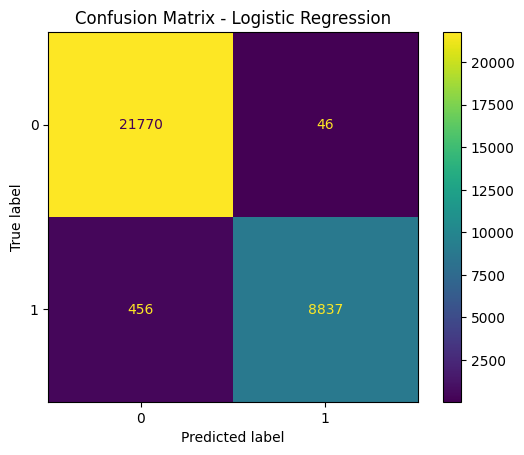


Training Random Forest...


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
import dask.dataframe as dd

#model = RandomForestClassifier(n_jobs=-1)

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay,
    classification_report, roc_curve
)

# Load data with low_memory=False
df = pd.read_csv('data/flights_delay.csv', low_memory=False)
#df = dd.read_csv('flights_delay.csv')

# Convert known problematic columns to string to avoid int/str mix
df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].astype(str)
df['SCHEDULED_DEPARTURE'] = df['SCHEDULED_DEPARTURE'].astype(str)

# Create target variable
df['ARR_DEL15'] = df['ARRIVAL_DELAY'].apply(lambda x: 1 if pd.notna(x) and x > 15 else 0)

# Drop irrelevant or redundant columns
df.drop(columns=[
    'FLIGHT_NUMBER', 'TAIL_NUMBER', 'YEAR', 'CANCELLED', 'CANCELLATION_REASON',
    'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME'
], inplace=True)

# Feature selection
features = [
    'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
    'DEPARTURE_DELAY', 'DISTANCE', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY',
    'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'
]
X = df[features]
y = df['ARR_DEL15']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Clean numeric features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Model pipelines
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

model = RandomForestClassifier(n_jobs=-1)

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Build full pipeline
    full_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Train
    full_pipeline.fit(X_train, y_train)

    # Predict
    y_pred = full_pipeline.predict(X_test)
    y_proba = full_pipeline.predict_proba(X_test)[:, 1]

    # Evaluate
    results[name] = {
        'pipeline': full_pipeline,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba),
        'report': classification_report(y_test, y_pred),
        'proba': y_proba
    }

    print("Accuracy:", results[name]['accuracy'])
    print("Precision:", results[name]['precision'])
    print("Recall:", results[name]['recall'])
    print("F1 Score:", results[name]['f1'])
    print("ROC AUC:", results[name]['roc_auc'])
    print("Classification Report:\n", results[name]['report'])

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f"Confusion Matrix - {name}")
    plt.savefig(f"figures/confusion_matrix_{name.replace(' ', '_')}.png")
    plt.show()

# Plot ROC Curve
plt.figure(figsize=(8, 6))
for name in models:
    fpr, tpr, _ = roc_curve(y_test, results[name]['proba'])
    plt.plot(fpr, tpr, label=f"{name} (AUC = {results[name]['roc_auc']:.2f}")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('figures/flight_roc_curve.png')
plt.show()
